# Part 2: Multiclass Classification w/ Classical Models

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-Libraries" data-toc-modified-id="Importing-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing Libraries</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#Processing-Datasets-For-Modeling" data-toc-modified-id="Processing-Datasets-For-Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Processing Datasets For Modeling</a></span><ul class="toc-item"><li><span><a href="#Image-Dataset-for-Multiclass-Classification-Using-Classic-Models" data-toc-modified-id="Image-Dataset-for-Multiclass-Classification-Using-Classic-Models-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Image Dataset for Multiclass Classification Using Classic Models</a></span></li><li><span><a href="#Augmented-Image-Dataset-for-Multiclass-Classification-Using-Classic-Models" data-toc-modified-id="Augmented-Image-Dataset-for-Multiclass-Classification-Using-Classic-Models-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Augmented Image Dataset for Multiclass Classification Using Classic Models</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Model-List" data-toc-modified-id="Model-List-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Model List</a></span></li><li><span><a href="#Testing-Image-Dataset-w/-Optimal-Model" data-toc-modified-id="Testing-Image-Dataset-w/-Optimal-Model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Testing Image Dataset w/ Optimal Model</a></span></li><li><span><a href="#Confusion-Matrix-for-Multiclass-Classification-w/out-Image-Augmentation" data-toc-modified-id="Confusion-Matrix-for-Multiclass-Classification-w/out-Image-Augmentation-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Confusion Matrix for Multiclass Classification w/out Image Augmentation</a></span></li><li><span><a href="#Modeling-Using-Augmented-Dataset" data-toc-modified-id="Modeling-Using-Augmented-Dataset-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Modeling Using Augmented Dataset</a></span></li><li><span><a href="#Confusion-Matrix-with-Augmented-Dataset" data-toc-modified-id="Confusion-Matrix-with-Augmented-Dataset-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Confusion Matrix with Augmented Dataset</a></span></li><li><span><a href="#Implementing-Ensemble-Methods" data-toc-modified-id="Implementing-Ensemble-Methods-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Implementing Ensemble Methods</a></span></li><li><span><a href="#Optimized-Confusion-Matrix" data-toc-modified-id="Optimized-Confusion-Matrix-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Optimized Confusion Matrix</a></span></li></ul></li></ul></div>

## Importing Libraries

In [12]:
import pandas as pd
import numpy as np
import glob
import os, shutil
import mahotas
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from keras.utils import to_categorical
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from skimage.color import rgb2gray
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, 
                             precision_recall_curve, f1_score, fbeta_score, roc_auc_score, roc_curve, classification_report)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import decomposition
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)
import warnings
warnings.filterwarnings('ignore');

## Exploratory Data Analysis

__Function To Read Images In Image Dataset:__

In [3]:
"""
Defining function to create an image directory with image names and their corresponding labels.
Each image in each folders are read and resized to (150,150). The images/labels are shuffled to make sure
that their is no biasness in model's learning due to the sequence in which the images appear.
"""
def images(image_directory):
    Images = []
    Labels = []
        
    for labels in os.listdir(image_directory): # "os.listdir(image_directory)" extracts the folder names in "image_directory".
        if labels == 'buildings': # Converting each string labels to numeric
            label = 0 
        elif labels == 'forest':
            label = 1
        elif labels == 'glacier':
            label = 2
        elif labels == 'mountain':
            label = 3
        elif labels == 'sea':
            label = 4
        elif labels == 'street':
            label = 5
        
        for image_file in os.listdir(image_directory+labels):
            image = cv.imread(image_directory+labels+r'/'+image_file)
            image = cv.resize(image,(150,150))
            Images.append(image)
            Labels.append(label)
            
    return shuffle(Images, Labels, random_state=42) 

In [4]:
Images, Labels = images('../seg_train/')

# Converting the list of images to an array
Images = np.array(Images)
Labels = np.array(Labels)

In [5]:
"""
Each images are in a matrix format where the numbers in the array/matrix refer to the R/G/B pixel values. 
The following shows R/G/B pixel values of the first pixel of the first image in the "Images" list. 
""" 
Images[0][0][0]

array([89, 99, 46], dtype=uint8)

In [6]:
"""
The following shows the numeric values of the labels of the images in the "Images" list. 
E.g., as shown above "1" corresponds to "forest".  
""" 
Labels

array([1, 4, 4, ..., 2, 1, 5])

__Retrieving String Class Labels:__

In [7]:
"""
"get_classlabel" function: returns string value of the label when it's provided with the numeric value of the label.
""" 
def get_classlabel(numeric_label):
    labels = {0:'buildings',1:'forest',2:'glacier',3:'mountain',4:'sea',5:'street'}
    return labels[numeric_label]

__Displaying Randomly Selected Images In The Image Dataset:__

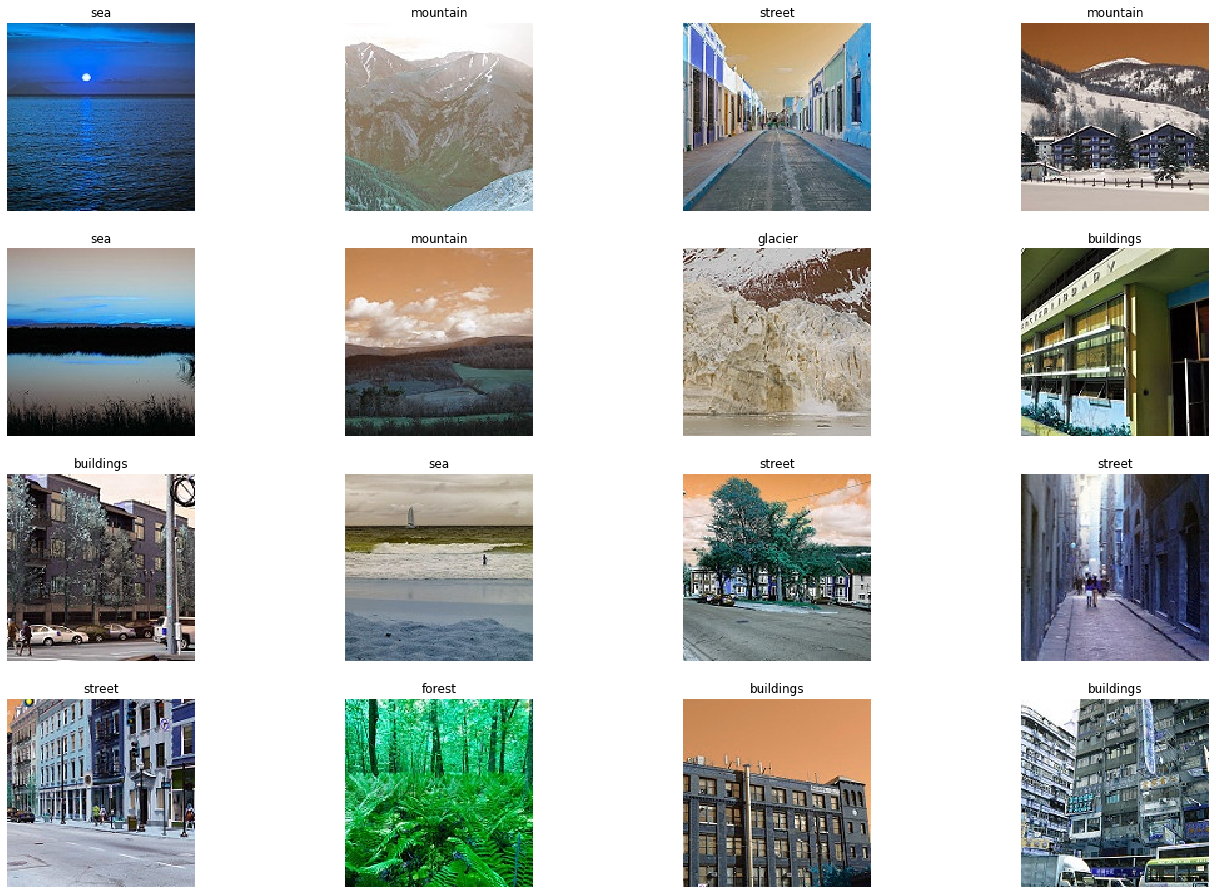

In [8]:
"""
Plotting 16 randomly selected images in the image dataset along with their labels on top.
""" 
f,ax = plt.subplots(4,4)
f.subplots_adjust(0,0,3,3)

for i in range(0,4,1):
    for j in range(0,4,1):
        random_number = randint(0,len(Images))
        ax[i,j].imshow(Images[random_number])
        ax[i,j].set_title(get_classlabel(Labels[random_number]))
        ax[i,j].axis(False)

## Processing Datasets For Modeling

After resizing the images, we preprocess the data for modeling which includes extracting features from the resized images and furthermore scaling the features!

### Image Dataset for Multiclass Classification Using Classic Models

In [16]:
"""
"image_features" function: extracts Hu Moments, Histogram of Oriented Gradients and Haralick features of each image. 
It scales the image features in the range (0,1).
Hu Moments: Quantifies the shape of an object in an image.
Histogram of Oriented Gradients: Quatifies the edges and its directions. In general, it extracts the gradient and orientation of the edges.
Haralick: Quantifies texture of an image. 
"""
def image_features(image_directory):
    global_features_multiclass = []
    labels_multiclass = []

    for labels in os.listdir(image_directory):
        if labels == 'buildings':
            label = 0
        elif labels == 'forest':
            label = 1
        elif labels == 'glacier':
            label = 2
        elif labels == 'mountain':
            label = 3
        elif labels == 'sea':
            label = 4
        elif labels == 'street':
            label = 5
        
        for image_file in os.listdir(image_directory+labels):
            image = cv.imread(image_directory+labels+r'/'+image_file)
            image = cv.resize(image,(150,150))

            image1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            hu_moments = cv2.HuMoments(cv2.moments(image1)).flatten()
            haralick = mahotas.features.haralick(image1).mean(axis=0).flatten()

            image2 = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

            hist  = cv2.calcHist([image2], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten()
            histogram = cv2.normalize(hist, hist)

            global_feature = np.hstack([histogram,haralick,hu_moments])

            global_features_multiclass.append(global_feature)
            labels_multiclass.append(label)
    
    le = LabelEncoder()
    target = le.fit_transform(labels_multiclass)

    scaler = MinMaxScaler(feature_range=(0, 1))
    global_features_multiclass = scaler.fit_transform(global_features_multiclass)

    global_features_multiclass  = np.array(global_features_multiclass)
    labels_multiclass = np.array(target)
    
    return global_features_multiclass, labels_multiclass

In [17]:
image_directory_multiclass = '../seg_train/'

global_features_multiclass, labels_multiclass = image_features(image_directory_multiclass)

After extracting features, we generate train and test dataset for modeling.

__Generating Train/Test Dataset__

In [18]:
"""
"train_test_split" function: splits feature & label data into training and test data in 80% and 20% ratio, respectively.
random_state=42: preserves the split such that it's reproducible when we rerun the code
"""

(train_imagedata_multiclass, test_imagedata_multiclass, train_labeldata_multiclass, test_labeldata_multiclass) = train_test_split(np.array(global_features_multiclass),
                                                                                          np.array(labels_multiclass),
                                                                                          test_size=0.2,
                                                                                          random_state=42)

### Augmented Image Dataset for Multiclass Classification Using Classic Models

Image augmentation is a neat trick to increase the number of images in the dataset by applying various mathematical transformations to a given image such as rotation, shear, zoom, etc. This enables better learning by the model.

__Generating Augmented Dataset for "sea"__

In [19]:
input_folder_sea = '../seg_train/sea'
output_folder_sea = '../multiclasss_augmented/sea'
prefix_sea = 'sea'

In [20]:
image_augmentation(input_folder_sea,output_folder_sea,prefix_sea)

__Generating Augmented Dataset for "mountain"__

In [21]:
input_folder_mountain = '../seg_train/mountain'
output_folder_mountain = '../multiclasss_augmented/mountain'
prefix_mountain = 'mountain'

In [22]:
image_augmentation(input_folder_mountain,output_folder_mountain,prefix_mountain)

__Generating Augmented Dataset for "mountain"__

In [23]:
input_folder_glacier = '../seg_train/glacier'
output_folder_glacier = '../multiclasss_augmented/glacier'
prefix_glacier = 'glacier'

In [24]:
image_augmentation(input_folder_glacier,output_folder_glacier,prefix_glacier)

__Generating Augmented Dataset for "street"__

In [25]:
input_folder_street = '../seg_train/street'
output_folder_street = '../multiclasss_augmented/street'
prefix_street = 'street'

In [26]:
image_augmentation(input_folder_street,output_folder_street,prefix_street)

__Creating List of Features & Labels__

In [27]:
multiclass_image_directory_augmented = '../multiclasss_augmented/'

global_features_multiclass_augmented, labels_multiclass_augmented = image_features(multiclass_image_directory_augmented)

__Generating Train/Test Dataset Using Augmented Images__

In [42]:
(train_imagedata_augmented_multiclass, test_imagedata_augmented_multiclass, train_labeldata_augmented_multiclass, test_labeldata_augmented_multiclass) = train_test_split(np.array(global_features_multiclass_augmented),
                                                                                          np.array(labels_multiclass_augmented),
                                                                                          test_size=0.2,
                                                                                          random_state=42)

## Modeling

### Model List

In [43]:
models = []
models.append(('LR', LogisticRegression(C=3.6)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(n_neighbors=6)))
models.append(('DT', DecisionTreeClassifier(max_depth=5)))
models.append(('RF', RandomForestClassifier(n_estimators=261,max_depth=29)))
models.append(('NB', GaussianNB()))
models.append(('XGBoost', XGBClassifier()))

__Retrieving Accuracy Score Of Different Models:__

In [30]:
"""
"score" function: returns each models' mean cross-validation score and plots the box-plot of metric vs. models. 
"""
def score(scoring,image_features,image_labels):
    model_cv_mean = []
    model_cv_results = []
    model_names   = []

    for name, model in models:
        kfold = KFold(n_splits=10, random_state=10)
        cv_results = cross_val_score(model, image_features, image_labels, cv=kfold, scoring=scoring)
        model_cv_results.append(cv_results)
        model_names.append(name)
        model_cv_mean.append(cv_results.mean())
        status = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(status)

    # Boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Model Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(model_cv_results)
    ax.set_xticklabels(model_names)
    plt.ylabel(str(scoring)+" "+"(x100 %)")
    plt.show()
    
    return model_cv_mean

LR: 0.621450 (0.010290)
LDA: 0.592679 (0.009326)
KNN: 0.549922 (0.011974)
DT: 0.558297 (0.011140)
RF: 0.671242 (0.011947)
NB: 0.435287 (0.019826)
XGBoost: 0.690037 (0.012043)


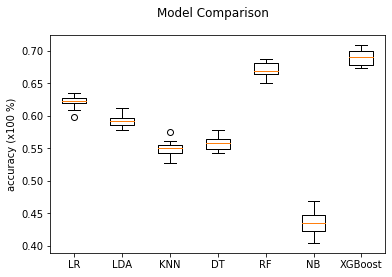

In [31]:
scoring    = "accuracy"

accuracy_list = score(scoring, train_imagedata_multiclass, train_labeldata_multiclass)

### Testing Image Dataset w/ Optimal Model

In [47]:
"""
"classification_accuracy" function: returns the classification accuracy of the test dataset
"""
def classification_accuracy(classifier, train_image_data, train_label_data, test_image_data, test_label_data):
    clf  = classifier

    # Fit the training data to the model
    clf = clf.fit(train_image_data, train_label_data)

    # Predict the response for test dataset
    y_pred = clf.predict(test_image_data)


    # Model Accuracy
    print("Classification Accuracy:",round(metrics.accuracy_score(test_label_data, y_pred)*100,2),'%')

In [33]:
classification_accuracy(XGBClassifier(),train_imagedata_multiclass,train_labeldata_multiclass,test_imagedata_multiclass,test_labeldata_multiclass)

Binary Classification Accuracy: 69.58 %


In [35]:
clf  = XGBClassifier()
clf = clf.fit(train_imagedata_multiclass,train_labeldata_multiclass)
y_pred = clf.predict(test_imagedata_multiclass)

print(classification_report(test_labeldata_multiclass, y_pred))

              precision    recall  f1-score   support

           0       0.54      0.51      0.53       439
           1       0.91      0.93      0.92       440
           2       0.70      0.69      0.70       495
           3       0.73      0.69      0.71       554
           4       0.63      0.59      0.61       437
           5       0.64      0.76      0.70       442

    accuracy                           0.70      2807
   macro avg       0.69      0.70      0.69      2807
weighted avg       0.70      0.70      0.69      2807



### Confusion Matrix for Multiclass Classification w/out Image Augmentation

In [36]:
class_names = ['mountain','street','glacier','buildings', 'sea','forest']

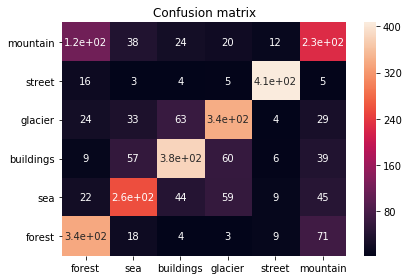

In [37]:
CM = confusion_matrix(test_labeldata_multiclass, y_pred)
ax = plt.axes()

sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t)
plt.xlim(b, t)
# plt.xlabel('Prediction',fontsize=15)
# plt.ylabel('Actual',fontsize=15)
plt.savefig('ConfusionMatrix_Multiclass.png',dpi=600)
plt.tight_layout()
plt.show()

### Modeling Using Augmented Dataset

LR: 0.668611 (0.006997)
LDA: 0.648026 (0.005510)
KNN: 0.929597 (0.002465)
DT: 0.568038 (0.003301)
RF: 0.948119 (0.003709)
NB: 0.460069 (0.007713)
XGBoost: 0.751308 (0.005754)


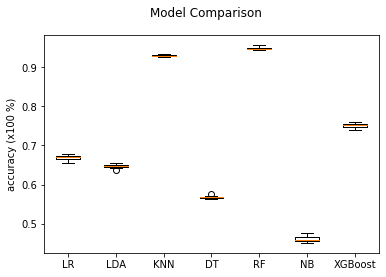

In [44]:
scoring    = "accuracy"

accuracy_list = score(scoring, train_imagedata_augmented_multiclass, train_labeldata_augmented_multiclass)

In [48]:
classification_accuracy(RandomForestClassifier(n_estimators=261,max_depth=29),train_imagedata_augmented_multiclass,train_labeldata_augmented_multiclass,test_imagedata_augmented_multiclass,test_labeldata_augmented_multiclass)

Classification Accuracy: 95.47 %


In [46]:
clf  = RandomForestClassifier(n_estimators=261,max_depth=29)
clf = clf.fit(train_imagedata_augmented_multiclass,train_labeldata_augmented_multiclass)
y_pred = clf.predict(test_imagedata_augmented_multiclass)

print(classification_report(test_labeldata_augmented_multiclass, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1962
           1       0.98      0.98      0.98      2004
           2       0.94      0.98      0.96      1981
           3       0.96      0.94      0.95      2013
           4       0.96      0.95      0.96      2017
           5       0.94      0.96      0.95      2022

    accuracy                           0.95     11999
   macro avg       0.95      0.95      0.95     11999
weighted avg       0.95      0.95      0.95     11999



### Confusion Matrix with Augmented Dataset

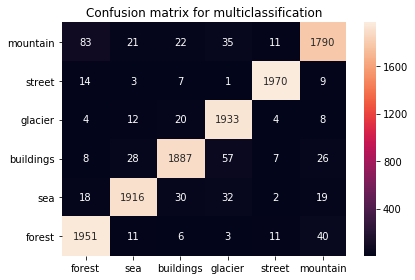

In [49]:
CM = confusion_matrix(test_labeldata_augmented_multiclass, y_pred)
ax = plt.axes()

sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax,fmt = 'd')
ax.set_title('Confusion matrix for multiclassification')
b, t = plt.ylim() # Values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t)
plt.xlim(b, t)
# plt.xlabel('Prediction',fontsize=15)
# plt.ylabel('Actual',fontsize=15)
plt.savefig('ConfusionMatrix_MulticlassAugmented.png',dpi=600)
plt.tight_layout()
plt.show()

### Implementing Ensemble Methods

In [51]:
KNN = KNeighborsClassifier(n_neighbors=6)
RF  = RandomForestClassifier(n_estimators=261,max_depth=29)

__Hard Voting Classifier__

In [52]:
hard_voting_classifier = VotingClassifier(estimators=[('KNN', KNN), ('RF', RF)], voting='hard')

In [53]:
hard_voting_classifier = hard_voting_classifier.fit(train_imagedata_augmented_multiclass, train_labeldata_augmented_multiclass)

In [54]:
y_pred_hardvotingclassifier = hard_voting_classifier.predict(test_imagedata_augmented_multiclass)

print("Multi Classification Accuracy w/ Augmented Dataset & Hard Voting Classifier:",round(metrics.accuracy_score(test_labeldata_augmented_multiclass, y_pred_hardvotingclassifier)*100,2),'%')

Multi Classification Accuracy w/ Augmented Dataset & Hard Voting Classifier: 94.1 %


__Soft Voting Classifier__

In [57]:
soft_voting_classifier = VotingClassifier(estimators=[('KNN', KNN), ('RF', RF)], voting='soft')

In [58]:
soft_voting_classifier = soft_voting_classifier.fit(train_imagedata_augmented_multiclass, train_labeldata_augmented_multiclass)

In [59]:
y_pred_softvotingclassifier = soft_voting_classifier.predict(test_imagedata_augmented_multiclass)

print("Multi Classification Accuracy w/ Augmented Dataset & Hard Voting Classifier:",round(metrics.accuracy_score(test_labeldata_augmented_multiclass, y_pred_softvotingclassifier)*100,2),'%')

Multi Classification Accuracy w/ Augmented Dataset & Hard Voting Classifier: 96.17 %


__Weighted Voting Classifier__

In [60]:
weighted_voting_classifier = VotingClassifier(estimators=[('KNN', KNN), ('RF', RF)], voting='soft',weights = [0.93,0.95])

In [61]:
weighted_voting_classifier = weighted_voting_classifier.fit(train_imagedata_augmented_multiclass, train_labeldata_augmented_multiclass)

In [62]:
y_pred_weightedvotingclassifier = weighted_voting_classifier.predict(test_imagedata_augmented_multiclass)

print("Multi Classification Accuracy w/ Augmented Dataset & Hard Voting Classifier:",round(metrics.accuracy_score(test_labeldata_augmented_multiclass, y_pred_weightedvotingclassifier)*100,2),'%')

Multi Classification Accuracy w/ Augmented Dataset & Hard Voting Classifier: 96.21 %


### Optimized Confusion Matrix

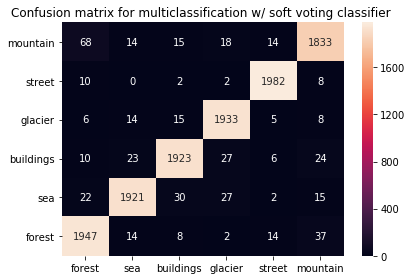

In [63]:
CM = confusion_matrix(test_labeldata_augmented_multiclass, y_pred_softvotingclassifier)
ax = plt.axes()

sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax,fmt = 'd')
ax.set_title('Confusion matrix for multiclassification w/ soft voting classifier ')
b, t = plt.ylim() # Values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t)
plt.xlim(b, t)
# plt.xlabel('Prediction',fontsize=15)
# plt.ylabel('Actual',fontsize=15)
plt.savefig('ConfusionMatrix_MulticlassAugmented_VotingClassifier.png',dpi=600)
plt.tight_layout()
plt.show()